In [1]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import confusion_matrix , classification_report

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump,load
import requests,json
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:

sheet_url='https://docs.google.com/spreadsheets/d/1MvIxVRBs4u6UFfvnu2khnU_gtrcoLUch5Tci-hcdkAk/edit#gid=635530870'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

df = pd.read_csv(csv_export_url)
df

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ( SE...,1
3,select * from users where id = '1' or @ @1 = ...,1
4,"select * from users where id = 1 or 1#"" ( un...",1
...,...,...
32993,DELETE FROM door WHERE grow='small',0
32994,DELETE FROM tomorrow,0
32995,SELECT wide(s) FROM west,0
32996,SELECT * FROM (SELECT slide FROM breath),0


In [3]:
# preprocess sql data to have same format for all files

def clean_sqli_data(data):
    
    for i in range(len(data)):
        
        data[i]=data[i].replace('\n', '')
        data[i]=data[i].replace('%20', ' ')
        data[i]=data[i].replace('%21', ' ')
        data[i]=data[i].replace('=', ' = ')
        data[i]=data[i].replace('((', ' (( ')
        data[i]=data[i].replace('))', ' )) ')
        data[i]=data[i].replace('(', ' ( ')
        data[i]=data[i].replace(')', ' ) ')
    
    return data

In [4]:

# removing the row if "Sentence" column contains null  value
df.dropna(subset = ["Sentence"], inplace=True)
# removing duplicate rows
df.drop_duplicates(inplace = True)

sql_lines=[]
labels=[]
# inserting dataframe data into list
for index, row in df.iterrows():
    sql_lines.append(row['Sentence'] )
    labels.append(row['Label'])
    #print(type(row['Sentence']))
    #print(row['Sentence'])


cleaned_data=clean_sqli_data(sql_lines)
cleaned_df = pd.DataFrame(list(zip(cleaned_data, labels)),columns =['Query', 'Label'])
cleaned_df

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0


In [5]:
cleaned_df.to_csv("Modified_SQL_Dataset.csv")


In [6]:
sheet_url='https://docs.google.com/spreadsheets/d/1Tgwe3WNobCLzVSSRYxEQRYixBClAQxUmiC-dSsiYLQA/edit#gid=1098375213'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

feature_table = pd.read_csv(csv_export_url)
#feature_table=feature_table.astype({'Label':'float'})
feature_table.head()


,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure,detectUtilityStmnt,Label
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [7]:
X = feature_table.drop(['Label'],axis='columns')
Y = feature_table['Label']

In [8]:
model_params1 = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20,30,40,45,50],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },
    
}

model_params2={
    'XGBoost':{
        'model': XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=10) ,
        'params':{
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }
    },
   
}
model_params3={
     'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}





In [9]:
def plot_loss_curve(clf):
    test_scores = clf.cv_results_['mean_test_score']
    train_scores = clf.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

In [10]:



def initGridSearch(x,y,model_params):
    scores = []

    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}
    reports={}
    for model_name, mp in model_params.items():
        grid =  GridSearchCV( mp['model'],
                             param_grid= mp['params'], 
                             cv=10,  # 10-fold cross validation
                             return_train_score=True,
                             n_jobs=-1)
        clf=grid.fit(x, y)
        # plot the training and validation curve
        plot_loss_curve(clf)
        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        reports[model_name] = report

        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']
        print("accuracy: "+str(accuracy)+" precision: "+str(macro_precision)+
              " recall:"+str(macro_recall)+" f1-score:"+str(macro_f1))

        scores.append({
            'model': model_name.upper(),
            'accuracy': accuracy,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,
            
        
        })
          
    return scores,reports,ConfusionMatrix
    


In [11]:
optimized_features= ['FetchCommandType','UpdateCommandType','InsertCommandType','DeleteCommandType','detectSortClause',
                     'detectWindowClause','detectComparisonOperator','detectSetOperation','detectNumberOfWithClause','detectStoredProcedure',
                     'detectLogicalOperator','detectArithmaticOperator','detectWindowFunc','detectSubQuery','detectStringConstant',
                     'detectBackslash','detectNumber']
print(len(optimized_features))
X[optimized_features]

17


,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectWindowClause,detectComparisonOperator,detectSetOperation,detectNumberOfWithClause,detectStoredProcedure,detectLogicalOperator,detectArithmaticOperator,detectWindowFunc,detectSubQuery,detectStringConstant,detectBackslash,detectNumber
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0
4,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30846,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
30847,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
30848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30849,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [12]:
def plot_loss_curve(clf):
    test_scores = clf.cv_results_['mean_test_score']
    train_scores = clf.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

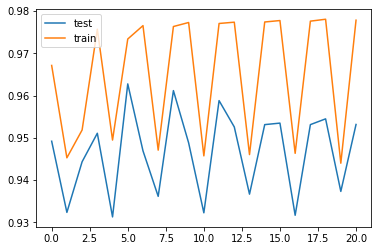

-------------------------------------------
SVM
-------------------------------------------
accuracy: 0.9731937376422158 precision: 0.9764170293442197 recall:0.9660428486525214 f1-score:0.9708382774766311


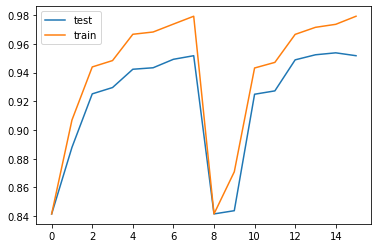

-------------------------------------------
DECISION_TREE
-------------------------------------------
accuracy: 0.9729992544812162 precision: 0.9761150759364994 recall:0.9659078682767777 f1-score:0.9706314121206443


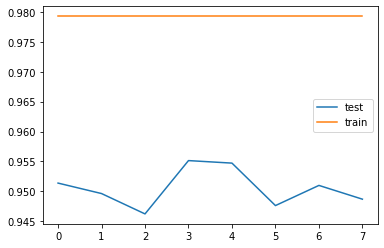

-------------------------------------------
ADABOOST
-------------------------------------------
accuracy: 0.9788337493112055 precision: 0.9790726057016784 recall:0.9752926493609869 f1-score:0.9771276037340367


In [ ]:
scores1,reports1,confusion_matrix1=initGridSearch(X[optimized_features],Y,model_params1)

In [ ]:
df1 = pd.DataFrame(scores1,columns=['model','accuracy','precision','recall','f1_score','best_params'])
df1.to_csv("Report1(without_resampling).csv")
df1

,model,accuracy,precision,recall,f1_score,best_params
0,SVM,0.973194,0.976417,0.966043,0.970838,"{'C': 10, 'kernel': 'poly'}"
1,DECISION_TREE,0.972999,0.976115,0.965908,0.970631,"{'criterion': 'entropy', 'max_depth': 7}"
2,ADABOOST,0.978834,0.979073,0.975293,0.977128,"{'base_estimator__criterion': 'gini', 'base_es..."


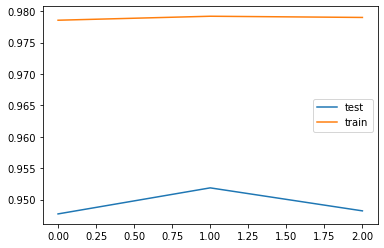

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
accuracy: 0.9788337493112055 precision: 0.9790726057016784 recall:0.9752926493609869 f1-score:0.9771276037340367


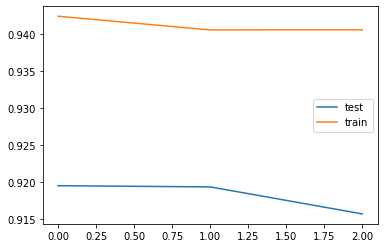

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
accuracy: 0.9289488185147969 precision: 0.9206326632221191 recall:0.9285772977470264 f1-score:0.924261379074684


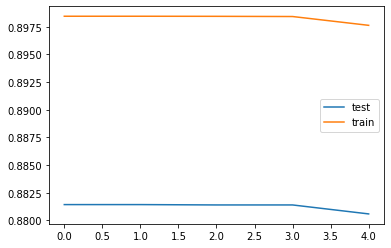

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
accuracy: 0.8810087193283849 precision: 0.8693186292775859 recall:0.880032836169828 f1-score:0.8738567198096399


In [ ]:
scores3,reports3,confusion_matrix3=initGridSearch(X[optimized_features],Y,model_params3)


In [ ]:
df3 = pd.DataFrame(scores3,columns=['model','accuracy','precision','recall','f1_score','best_params'])
df3.to_csv("Report3(without_resampling).csv")
df3

,model,accuracy,precision,recall,f1_score,best_params
0,RANDOM_FOREST,0.978834,0.979073,0.975293,0.977128,{'n_estimators': 5}
1,LOGISTIC_REGRESSION,0.928949,0.920633,0.928577,0.924261,{'C': 1}
2,NAIVE_BAYES:BERNOULLINB,0.881009,0.869319,0.880033,0.873857,{'alpha': 0.01}


In [ ]:
scores2,reports2,confusion_matrix2=initGridSearch(X[optimized_features],Y,model_params2)

In [ ]:
df2 = pd.DataFrame(scores2,columns=['model','accuracy','precision','recall','f1_score','best_params'])
df2.to_csv("Report2(without_resampling).csv")
df2